In [1]:
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

import torch
import torch.nn as nn

import time

# Interval is [0.5, 2.5]
%matplotlib widget

In [ ]:
class DeepliftingSimpleModel(nn.Module):
    def __init__(
        self,
    ):
        super(DeepliftingSimpleModel, self).__init__()

        # # One simple linear layer the input size will be 3
        # self.intermediate_linear_layer = nn.Linear(2, 2)

        self.linear_layer = nn.Linear(2, 1, bias=False)

        # # Simple input
        # self.x = nn.Parameter(torch.randn(1, 2))

    def get_linear_layer(self, inputs):
        return self.intermediate_linear_layer(inputs)

    def get_output_layer(self, inputs):
        output = self.linear_layer(inputs)
        return output

    def forward(self, inputs=None):
        if inputs is None:
            x = self.x
        else:
            x = inputs

        output = self.get_output_layer(x)

        # a & b are known for this example
        a, b = 0.5, 2.5
        return a + (b - a) / 2.0 * (torch.sin(output) + 1)
        return output


def objective(x):
    return torch.sin(10 * torch.pi * x) / (2 * x) + (x - 1) ** 4


def deeplifting_fn(x, model, objective, weights_list):
    """
    Combined funtion used for PyGranso
    """
    outputs = model(inputs=x)

    # Save the weights
    weights = [weights for name, weights in model.named_parameters()]
    weights_list.append(weights[0].detach().cpu().numpy())

    # Get x1 and x2 so we can add the bounds
    # outputs = torch.sigmoid(outputs)
    # x = outputs.mean(axis=0)
    # print(f'Output x {x}')
    f = objective(outputs)

    # Inequality constraint
    ci = None

    # Equality constraing
    ce = None

    return f, ci, ce

In [ ]:
device = torch.device('cpu')

# Deeplifting model with skip connections
model = DeepliftingSimpleModel()
model = model.to(device=device, dtype=torch.double)

model.train()
nvar = getNvarTorch(model.parameters())

# Setup a pygransoStruct for the algorithm
# options
opts = pygransoStruct()

# Inital x0
x0 = (
    torch.nn.utils.parameters_to_vector(model.parameters())
    .detach()
    .reshape(nvar, 1)
    .to(device=device, dtype=torch.double)
)

opts.x0 = x0
opts.torch_device = device
opts.print_frequency = 1
opts.limited_mem_size = 100
opts.stat_l2_model = False
opts.double_precision = True
opts.opt_tol = 1e-10
opts.maxit = 1000

x = torch.randn(1, 2)
x = x.to(device=device, dtype=torch.double)

# Set up the function with the results
# # Combined function
weights_list = []
comb_fn = lambda model: deeplifting_fn(
    x,
    model,
    objective,
    weights_list,
)  # noqa

# Run the main algorithm
start_time = time.time()
soln = pygranso(var_spec=model, combined_fn=comb_fn, user_opts=opts)
end_time = time.time()
total_time = end_time - start_time

In [ ]:
input = x
input

In [ ]:
import numpy as np

weights = np.vstack(weights_list)
x_min, x_max = np.round(weights[:, 0].min()) - 2.5, np.round(weights[:, 0].max()) + 2.5
y_min, y_max = np.round(weights[:, 1].min()) - 2.5, np.round(weights[:, 1].max()) + 2.5

(x_min, x_max, y_min, y_max)

In [ ]:
x = torch.linspace(x_min, x_max, steps=1000)
y = torch.linspace(y_min, y_max, steps=1000)

x_flat = torch.meshgrid(x, y)[0].flatten()
y_flat = torch.meshgrid(x, y)[1].flatten()

weights = torch.stack((x_flat, y_flat)).T.to(device=device, dtype=torch.double)
weights

In [ ]:
a, b = 0.5, 2.5
Z = objective(a + (b - a) / 2.0 * (torch.sin(input @ weights.T) + 1))
# Z = a + (b - a) / 2.0 * (torch.sin(input @ weights.T) + 1)
# Z = (input @ weights.T)

In [ ]:
x = torch.linspace(x_min, x_max, steps=1000)
y = torch.linspace(y_min, y_max, steps=1000)

In [ ]:
Z = Z.reshape(1000, 1000).detach().cpu().numpy()

In [ ]:
X, Y = torch.meshgrid(x, y)
X = X.numpy()
Y = Y.numpy()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up a figure and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot a surface
ax.plot_surface(X, Y, Z, cmap='YlOrRd_r')

In [ ]:
plt.figure()

# Create a contour plot
contour = plt.contourf(
    X, Y, Z, 20, cmap='YlOrRd_r'
)  # contourf fills the regions between contours
plt.colorbar(contour)  # Show a colorbar that maps color to Z values

In [ ]:
model(inputs=input)

In [ ]:
[i for i in model.named_parameters()]

In [ ]:
objective(model(inputs=input))

In [ ]:
%pwd
%cd ../..

In [ ]:
# Get the plot of the surface
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Define the layout
layout = """
    AB
"""

fig = plt.figure(figsize=(14, 4))
ax_dict = fig.subplot_mosaic(
    layout,
)

points = np.stack([points.flatten() for points in weights_list])
points = points[[1, 2, 3, 4, -1]]
x_values = points[:, 0]
y_values = points[:, 1]

# Contour plot
c = ax_dict['A'].contourf(X, Y, Z, 5, cmap='coolwarm')
ax_dict['A'].scatter(x_values, y_values, color='black')

# for color_idx, (x, y) in enumerate(points):
for i in range(len(points)):
    x1, y1 = points[i]

    # Add the annotation
    ax_dict['A'].annotate(
        str(i + 1),
        xy=(x1, y1),
        xytext=(5, 5),
        textcoords='offset points',
        color='black',
    )
# divider = make_axes_locatable(ax_dict['A'])
# cax = divider.append_axes("right", size="15%")
# fig.colorbar(c, cax=cax, orientation='horizontal')
fig.colorbar(c, orientation='vertical')
# ax_dict['A'].axis('off')
ax_dict['A'].set_title('Lifted Contour Plot')
ax_dict['A'].set_xlabel('$ \\theta _1$')
ax_dict['A'].set_ylabel('$ \\theta _2$')

# Histogram
ax_dict['B'].hist(Z.ravel(), bins=50, color='grey', alpha=0.7, density=True)
ax_dict['B'].set_title('Objective Values Evaluted in Lifted Space')
ax_dict['B'].set_xlabel('$f$ Values In Original Space')
ax_dict['B'].set_ylabel('Frequency')

# z = torch.tensor(Z.ravel())
# f = objective(z).cpu().numpy()

# ax_dict['C'].scatter(z, f)
# ax_dict['C'].set_title('Gramacy and Lee Function')

plt.subplots_adjust(hspace=0.6)

# # fig.tight_layout()
# fig.savefig(
#     './images/deeplifting_proof_of_concept_v3.png', bbox_inches='tight', pad_inches=0.04
# )

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 12))
c = plt.contourf(X, Y, Z, 5, cmap='coolwarm')
ax.scatter(x_values, y_values, color='black')

for i in range(len(points)):
    x1, y1 = points[i]

    # Add the annotation
    ax.annotate(
        str(i + 1),
        xy=(x1, y1),
        xytext=(5, 5),
        textcoords='offset points',
        color='black',
    )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create a simple dataset
D = 2  # Input dimension
K = 1  # Output dimension
N = 1  # Number of data points
X = np.random.randn(N, D)
y = np.random.randn(N, K)


def objective(x):
    return np.sin(10 * np.pi * x) / (2 * x) + (x - 1) ** 4


# Define the neural network
def forward_pass(W, X):
    output = X.dot(W)
    a, b = 0.5, 2.5
    return a + (b - a) / 2.0 * (np.sin(output) + 1)


# Define the loss function (Mean Squared Error)
def loss(W, X, y):
    y_pred = forward_pass(W, X)
    return objective(y_pred)


# Scan the loss landscape
res = 100  # Resolution of the scan
W0_range = np.linspace(-10, 10, res)
W1_range = np.linspace(-10, 10, res)
Z = np.zeros((res, res))

for i, w0 in enumerate(W0_range):
    for j, w1 in enumerate(W1_range):
        W = np.array([[w0], [w1]])
        Z[i, j] = loss(W, X, y)

# Plot the loss landscape
plt.contourf(W0_range, W1_range, Z, levels=100, cmap='YlOrRd_r')
plt.colorbar()
plt.title("Loss Landscape")
plt.xlabel("Weight of Neuron 1")
plt.ylabel("Weight of Neuron 2")
plt.show()

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Create a simple dataset
D = 2  # Input dimension
K = 1  # Output dimension
N = 1  # Number of data points
X = np.random.randn(N, D)
y = np.random.randn(N, K)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32, requires_grad=False)
y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=False)

# Initialize the weights with requires_grad=True to compute gradients
W = torch.tensor([[0.5], [0.5]], dtype=torch.float32, requires_grad=True)

# Compute the loss
y_pred = X_tensor @ W
loss = ((y_pred - y_tensor) ** 2).mean()

# Compute gradient
loss.backward()  # This will compute the gradient and store it in W.grad
gradient = W.grad.clone()  # Store the gradient before computing the Hessian

# Compute Hessian
hessian = torch.zeros((W.numel(), W.numel()))
# for idx, g in enumerate(gradient.view(-1)):
#     # Clear old gradient
#     W.grad.zero_()

#     # Compute gradient of the current gradient component
#     g.backward(retain_graph=True)

#     # Store the result in the Hessian matrix
#     hessian[idx] = W.grad.view(-1)

# print("Gradient:", gradient)
# print("Hessian:\n", hessian)

In [ ]:
def objective(x):
    return torch.sin(10 * torch.pi * x) / (2 * x) + (x - 1) ** 4


def func(W):
    a, b = 0.5, 2.5
    output = X_tensor @ W
    output = a + (b - a) / 2.0 * (torch.sin(output) + 1)
    return objective(output)

In [ ]:
from torch.autograd.functional import hessian

W = torch.tensor([[0.5], [0.5]], dtype=torch.float32, requires_grad=True)
H = hessian(func, W).reshape(2, 2)

In [ ]:
loss = func(W)
loss.backward()
W.grad

In [ ]:
import numpy as np


def is_psd(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    print(eigenvalues)
    return all(eigenvalue >= 0 for eigenvalue in eigenvalues)


# Example:
hessian_np = (
    H.detach().numpy()
)  # Assuming 'hessian' is the tensor from the previous code
print(is_psd(hessian_np))

In [125]:
from torch.autograd.functional import hessian
import torch
import numpy as np

np.random.seed(0)


# def objective(x):
#     return torch.sin(10 * torch.pi * x) / (2 * x)  + (x - 1) ** 4


def objective(x):
    return x**2


def func(W, wr):
    a, b = -2.5, 2.5
    output = wr @ X_tensor.T

    output = output.T @ W
    # output = torch.nn.ReLU()(output)
    output = a + (b - a) / 2.0 * (torch.sin(2 * np.pi * output) + 1)
    # print(output)
    return objective(output)


# Create a simple dataset
D = 2  # Input dimension
K = 1  # Output dimension
N = 1  # Number of data points
X = np.random.rand(N, D)
y = np.random.rand(N, K)
wr = torch.randn((2, 2), dtype=torch.double)
print(wr, X)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.double, requires_grad=False)
y_tensor = torch.tensor(y, dtype=torch.double, requires_grad=False)

# Now let W vary and we can calculate all of these things as we expand the space
resolution = 100
W0_range = np.linspace(-2, 2, resolution)
W1_range = np.linspace(-2, 2, resolution)
# W0_range = np.random.randn(100) * 2
# W1_range = np.random.randn(100) * 2
Z = np.zeros((resolution, resolution))
GRAD = np.zeros((resolution, resolution))
HESS_PROD = np.zeros((resolution, resolution))

obj = lambda w: func(w, wr)

for i, W0 in enumerate(W0_range):
    for j, W1 in enumerate(W1_range):
        W = torch.tensor([[W0], [W1]], dtype=torch.double, requires_grad=True)

        # First calculate the gradient
        loss = obj(W)
        Z[i, j] = loss.detach().cpu().numpy().flatten()[0]

        loss.backward()
        gradient = W.grad.view(-1)
        GRAD[i, j] = np.max(gradient.detach().cpu().numpy())

        # Calculate the hessian
        H = hessian(obj, W)
        H = H.reshape(2, 2)
        hessian_np = H.detach().numpy()
        eigenvalues = np.linalg.eigvals(hessian_np)

        # if Z[i, j] < -0.869:
        #     import pdb; pdb.set_trace()

        if np.all(eigenvalues >= 0):
            value = -1
        elif np.all(eigenvalues <= 0):
            value = 0
        elif np.all(eigenvalues == 0):
            value = 1
        # else:
        #     value = 2
        HESS_PROD[i, j] = np.prod(eigenvalues)

tensor([[ 0.9601, -1.2577],
        [-0.6307,  1.7956]], dtype=torch.float64) [[0.5488135  0.71518937]]


In [126]:
isolated_z_minimum = Z.copy()
isolated_z_minimum[isolated_z_minimum > 0.1] = 1.0

In [127]:
Z.min()

1.1064445750528533e-06

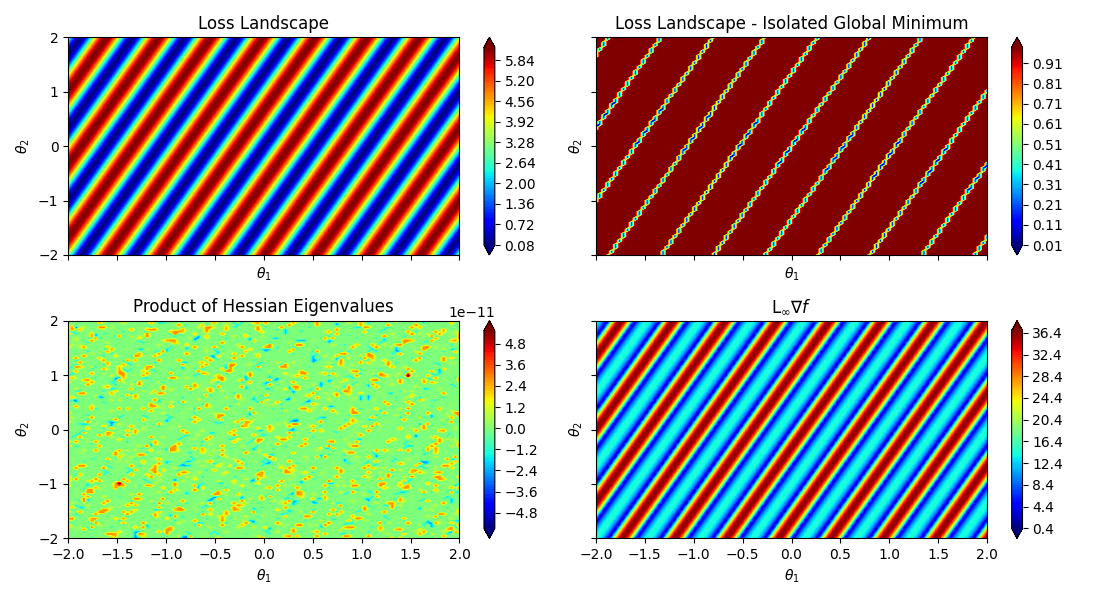

In [128]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(11, 6), sharex=True, sharey=True
)

# Plot the weights vs. the loss landscale
c1 = ax1.contourf(W0_range, W1_range, Z, levels=100, cmap='jet', extend='both')
ax1.set_title("Loss Landscape")
ax1.set_xlabel("$ \\theta _1$")
ax1.set_ylabel("$ \\theta _2$")

fig.colorbar(c1, orientation='vertical')

# Plot the weights vs. the isolated minimum values
c2 = ax2.contourf(
    W0_range, W1_range, isolated_z_minimum, levels=100, cmap='jet', extend='both'
)
ax2.set_title("Loss Landscape - Isolated Global Minimum")
ax2.set_xlabel("$ \\theta _1$")
ax2.set_ylabel("$ \\theta _2$")

fig.colorbar(c2, orientation='vertical')

# Plot of max hessian values vs. weights
c3 = ax3.contourf(W0_range, W1_range, HESS_PROD, levels=100, cmap='jet', extend='both')
ax3.set_title("Product of Hessian Eigenvalues")
ax3.set_xlabel("$ \\theta _1$")
ax3.set_ylabel("$ \\theta _2$")

fig.colorbar(c3, orientation='vertical')

# Plot of max gradient value vs. weights
c4 = ax4.contourf(W0_range, W1_range, GRAD, levels=100, cmap='jet', extend='both')
ax4.set_title("L$_{\\infty} \\nabla f$")
ax4.set_xlabel("$ \\theta _1$")
ax4.set_ylabel("$ \\theta _2$")

fig.colorbar(c4, orientation='vertical')

fig.tight_layout()
# fig.savefig('/Users/ryandevera/data-science/umn_environments/Deeplifting/paper-images/loss-landscape.png')

In [129]:
minima = [
    -1.0,
    -3.0,
    -6.0,
    -9.103852,
    -12.712062,
    -16.505384,
    -19.821489,
    -24.113360,
    -28.422532,
    -32.765970,
    -37.967600,
    -44.326801,
    -47.845157,
    -52.322627,
    -56.815742,
    -61.317995,
    -66.530949,
    -72.659782,
    -77.1777043,
]

dimensions = 30
k = int(dimensions / 3)
minima[k - 2]

-28.422532